In [37]:
import sys
import os
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
sys.path.append(os.path.abspath('../src'))

from read_and_write_docs import read_jsonl, write_jsonl

In [3]:
para_0_7 = "/Volumes/BCross/datasets/author_verification/training/Wiki/Qwen_2.5_1.5B/top_impostors"
para_1_5 = '/Volumes/BCross/datasets/author_verification/training/Wiki/Qwen_2.5_1.5B/para_t_1.5_tp_0.9/top_impostors'
gen_0_7 = '/Volumes/BCross/datasets/author_verification/training/Wiki/Qwen_2.5_1.5B/gen_t_0.7_tp_0.9/top_impostors'
gen_1_0 = '/Volumes/BCross/datasets/author_verification/training/Wiki/Qwen_2.5_1.5B/gen_t_1.0_tp_0.9/top_impostors'
gen_1_2 = '/Volumes/BCross/datasets/author_verification/training/Wiki/Qwen_2.5_1.5B/gen_t_1.2_tp_0.9/top_impostors'
gen_1_5 = '/Volumes/BCross/datasets/author_verification/training/Wiki/Qwen_2.5_1.5B/gen_t_1.5_tp_0.9/top_impostors'
sim_0_7 = '/Volumes/BCross/datasets/author_verification/training/Wiki/Qwen_2.5_1.5B/sim_para_t_0.7_tp_0.9/top_impostors'
sim_1_0 = '/Volumes/BCross/datasets/author_verification/training/Wiki/Qwen_2.5_1.5B/sim_para_t_1.0_tp_0.9/top_impostors'
sim_1_2 = '/Volumes/BCross/datasets/author_verification/training/Wiki/Qwen_2.5_1.5B/sim_para_t_1.2_tp_0.9/top_impostors'
sim_1_5 = '/Volumes/BCross/datasets/author_verification/training/Wiki/Qwen_2.5_1.5B/sim_para_t_1.5_tp_0.9/top_impostors'

parascore_dirs = {
    'para_0_7': para_0_7,
    'para_1_5': para_1_5,
    'gen_0_7' : gen_0_7,
    'gen_1_0' : gen_1_0,
    'gen_1_2' : gen_1_2,
    'gen_1_5' : gen_1_5,
    'sim_0_7' : sim_0_7,
    'sim_1_0' : sim_1_0,
    'sim_1_2' : sim_1_2,
    'sim_1_5' : sim_1_5,
}

In [4]:
def read_all_jsonl(dir_map):
    """
    Walk through each directory in dir_map (name→path),
    try reading all .jsonl files, insert a 'description' column,
    report per-directory success counts, and concatenate results.
    """
    dfs = []
    for name, base_dir in dir_map.items():
        print(f"Getting '{name}' data…")
        paths = list(Path(base_dir).rglob('*.jsonl'))
        total = len(paths)
        success_count = 0

        for path in paths:
            try:
                df = read_jsonl(path)
                # If your loader can return None or empty DataFrame:
                if df is None or df.empty:
                    print(f"  → Warning: {path!r} returned no rows")
                    continue

                df.insert(0, 'description', name)
                dfs.append(df)
                success_count += 1

            except Exception as e:
                print(f"  → ERROR reading {path!r}: {e}")

        print(f"Loaded {success_count}/{total} files for '{name}'\n")

    if dfs:
        combined = pd.concat(dfs, ignore_index=True)
        print(f"Total combined rows: {combined.shape[0]}")
        return combined
    else:
        print("No data loaded; returning empty DataFrame.")
        return pd.DataFrame()


In [74]:
def summarise_jsonl_dirs(dir_map, cols):
    """
    For each (name → directory) in dir_map:
      - Read every .jsonl under that directory via global read_jsonl(path)
      - Skip empty/None results, insert a 'description' column = name
    Then, for each column in `cols` that exists, compute per-directory:
      count, mean, std, min, 25%, 50%, 75%, max

    Returns a dict mapping each col in `cols` to a DataFrame of its stats:
      output[col] has columns
      ['description','count','mean','std','min','25%','50%','75%','max'].
    """
    dfs = []
    for name, base_dir in dir_map.items():
        paths = list(Path(base_dir).rglob('*.jsonl'))
        for path in paths:
            try:
                df = read_jsonl(path)
                if df is None or df.empty:
                    continue
                df.insert(0, 'description', name)
                dfs.append(df)
            except Exception:
                # skip any file that errors
                continue

    if not dfs:
        return {}

    combined = pd.concat(dfs, ignore_index=True)
    output = {}
    for col in cols:
        if col not in combined.columns:
            continue
        stats = (
            combined
            .groupby('description')[col]
            .describe()
            .reset_index()
        )
        output[col] = stats

    return output

In [5]:
def distribution_plot(df,
                      score_col='score',
                      xlabel='Score',
                      ylabel='Count',
                      title='Score Distribution',
                      group_col=None,
                      bins=30):
    """
    Plots score distributions as histograms, optionally facetted by a grouping column.

    Parameters:
    -----------
    df : pandas.DataFrame
        Must contain the score column (numeric).
    score_col : str
        Column name for the scores to histogram.
    xlabel, ylabel, title : str
        Plot labels and overall title.
    group_col : str or None
        If provided, column name to group by; creates one subplot per unique value.
    bins : int
        Number of bins in each histogram.
    """
    def _plot_panel(ax, subdf):
        subdf[score_col].dropna().hist(
            ax=ax, bins=bins, alpha=0.7
        )
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid(False)

    if group_col is None:
        # Single panel
        fig, ax = plt.subplots(figsize=(8, 5))
        _plot_panel(ax, df)
        ax.set_title(title)
        fig.tight_layout()
        plt.show()

    else:
        groups = df[group_col].dropna().unique()
        n = len(groups)
        # balance as square as possible
        ncols = int(math.ceil(math.sqrt(n)))
        nrows = int(math.ceil(n / ncols))
        fig, axes = plt.subplots(nrows, ncols,
                                 figsize=(4 * ncols, 3 * nrows),
                                 squeeze=False)

        for idx, grp in enumerate(groups):
            ax = axes.flat[idx]
            subdf = df[df[group_col] == grp]
            _plot_panel(ax, subdf)
            ax.set_title(f"{group_col} = {grp}")

        # Hide any unused axes
        for idx in range(n, nrows * ncols):
            axes.flat[idx].set_visible(False)

        fig.suptitle(title, fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

In [6]:
def distribution_plot(df,
                      score_col='score',
                      xlabel='Score',
                      ylabel='Count',
                      title='Score Distribution',
                      group_col=None,
                      bins=30):
    """
    Plots score distributions as histograms, optionally facetted by a grouping column,
    and forces all x-axes to share the same range.
    """
    # Compute the global min/max of the scores (ignoring NaNs)
    scores = df[score_col].dropna()
    global_min, global_max = scores.min(), scores.max()
    hist_kwargs = dict(bins=bins, range=(global_min, global_max), alpha=0.7)

    def _plot_panel(ax, subdf):
        subdf[score_col].dropna().hist(ax=ax, **hist_kwargs)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xlim(global_min, global_max)
        ax.grid(False)

    if group_col is None:
        fig, ax = plt.subplots(figsize=(8, 5))
        _plot_panel(ax, df)
        ax.set_title(title)
        fig.tight_layout()
        plt.show()

    else:
        groups = df[group_col].dropna().unique()
        n = len(groups)
        ncols = int(math.ceil(math.sqrt(n)))
        nrows = int(math.ceil(n / ncols))
        fig, axes = plt.subplots(nrows, ncols,
                                 figsize=(4 * ncols, 3 * nrows),
                                 squeeze=False)
        for idx, grp in enumerate(groups):
            ax = axes.flat[idx]
            subdf = df[df[group_col] == grp]
            _plot_panel(ax, subdf)
            ax.set_title(f"{group_col} = {grp}")
        # Hide unused axes
        for idx in range(n, nrows * ncols):
            axes.flat[idx].set_visible(False)

        fig.suptitle(title, fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


In [24]:
def distribution_plots(df,
                       score_cols,
                       xlabel='Score',
                       ylabel='Count',
                       title='Score Distributions',
                       bins=30,
                       figsize_per_plot=(4, 3)):
    """
    Plots multiple score distributions as separate histograms, side by side,
    each with its own x-axis scale.

    Parameters
    ----------
    df : pandas.DataFrame
        Your data.
    score_cols : list of str
        Column names in `df` to plot.
    xlabel, ylabel : str
        Axis labels.
    title : str
        Overall figure title.
    bins : int
        Number of histogram bins.
    figsize_per_plot : tuple
        (width, height) per subplot in inches.
    """
    n = len(score_cols)
    fig, axes = plt.subplots(1, n,
                             figsize=(figsize_per_plot[0] * n,
                                      figsize_per_plot[1]),
                             sharex=False, squeeze=True)

    # If n==1, axes might not be an array
    if n == 1:
        axes = [axes]

    for ax, col in zip(axes, score_cols):
        df[col].dropna().hist(ax=ax, bins=bins, alpha=0.7)
        ax.set_title(col)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid(False)

    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [75]:
def histogram_tables(df, score_cols, bins=30, range=None, long_format=False):
    """
    Compute histograms for each score column and return tables of bin counts.
    
    Parameters
    ----------
    df : pandas.DataFrame
    score_cols : list of str
      Columns to tabulate.
    bins : int or sequence
      Passed to np.histogram.
    range : tuple (min, max), optional
      Passed to np.histogram to fix the same bin edges across all columns.
    long_format : bool
      If False, returns dict[col] = DataFrame(bin_left, bin_right, count).
      If True, returns one DataFrame with columns: column, bin_left, bin_right, count.
    """
    all_tables = {}
    for col in score_cols:
        data = df[col].dropna().values
        counts, edges = np.histogram(data, bins=bins, range=range)
        tbl = pd.DataFrame({
            'bin_left': edges[:-1],
            'bin_right': edges[1:],
            'count': counts
        })
        all_tables[col] = tbl
    
    if not long_format:
        return all_tables
    
    # build one long DataFrame
    rows = []
    for col, tbl in all_tables.items():
        tmp = tbl.copy()
        tmp['column'] = col
        rows.append(tmp)
    return pd.concat(rows, ignore_index=True)[['column','bin_left','bin_right','count']]

In [7]:
#combined = read_all_jsonl(parascore_dirs)

In [8]:
# write_jsonl(combined, "/Volumes/BCross/datasets/author_verification/training/Wiki/Qwen_2.5_1.5B/combined_parascore.jsonl")

In [9]:
# combined = read_jsonl("/Volumes/BCross/datasets/author_verification/training/Wiki/Qwen_2.5_1.5B/combined_parascore.jsonl")

In [67]:
parascore_dirs = {
    'sim 0.7': gen_1_5
}
combined = read_all_jsonl(parascore_dirs)

Getting 'sim 0.7' data…
Loaded 218/218 files for 'sim 0.7'

Total combined rows: 65400


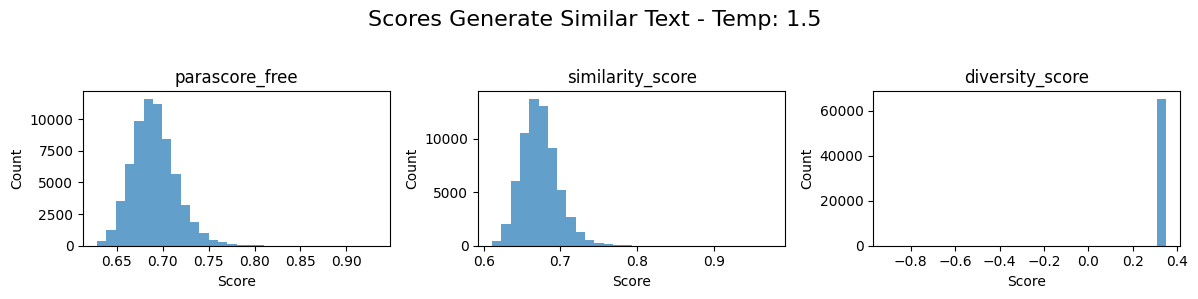

In [68]:
distribution_plots(combined, ['parascore_free', 'similarity_score', 'diversity_score'], title="Scores Generate Similar Text - Temp: 1.5")

In [66]:
pd.DataFrame(histogram_tables(combined, ['diversity_score'])['diversity_score'])

,bin_left,bin_right,count
0,-0.952926,-0.909495,8
1,-0.909495,-0.866064,6
2,-0.866064,-0.822633,5
3,-0.822633,-0.779202,2
4,-0.779202,-0.735771,3
5,-0.735771,-0.692341,4
6,-0.692341,-0.648910,2
7,-0.648910,-0.605479,4
8,-0.605479,-0.562048,2
9,-0.562048,-0.518617,3


In [70]:
parascore_dirs = {
    'para_0_7': para_0_7,
    'para_1_5': para_1_5,
    'gen_0_7' : gen_0_7,
    'gen_1_0' : gen_1_0,
    'gen_1_2' : gen_1_2,
    'gen_1_5' : gen_1_5,
    'sim_0_7' : sim_0_7,
    'sim_1_0' : sim_1_0,
    'sim_1_2' : sim_1_2,
    'sim_1_5' : sim_1_5,
}

In [ ]:
summary_results = summarise_jsonl_dirs(parascore_dirs, cols=['parascore_free', 'similarity_score', 'diversity_score'])

In [73]:
summary_results['similarity_score']

,count,mean,std,min,25%,50%,75%,max
similarity_score,586184.0,0.706404,0.044319,0.0,0.676843,0.698672,0.726954,1.0
